# ARIMA-GARCH Trading Strategy : Short-term Forecasting (1 Step Ahead)

## Importing libraries

In [34]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go


from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import pickle


import warnings
warnings.filterwarnings("ignore")

## Setting the Strategy : Defining the used function

In [13]:
def resid_stationarity_test():
    adf_result = adfuller(data, regression=reg_parm, autolag = "AIC")
    if (adf_result[1] <= 0.05):
        x = True
    else:
        x = False
    return x

In [14]:
def ARCH_test(data, p, q):
    from statsmodels.stats.diagnostic import het_arch
    test  = het_arch(data, ddof=p+q)
    if (test[-1] <= 0.05):
        x = True
    else:
        x = False
    return x

In [15]:
def arima_tuning(data, reg_parm, trend, max_p, max_q): # Finding the best ARIMA parameters
    adf_result = adfuller(data, regression=reg_parm, autolag = "AIC")
    if (adf_result[1] <= 0.05):
        d = 0
    else:
        diff = data.diff(periods=1).dropna()
        adf_result = adfuller(diff, regression=reg_parm, autolag = "AIC")
        if (adf_result[1] <= 0.05):
            d = 1
        else:
            diff = diff.diff(periods=1).dropna()
            adf_result = adfuller(diff, regression=reg_parm, autolag = "AIC")
            if (round(adf_result[1], 4) <= 0.05):
                d = 2
    AIC = {}
    for p in range(max_p):
        for q in range(max_q):
            model = ARIMA(data, trend=trend, order=(p,d,q)).fit()
            n=0
            for i in model.pvalues:
                if (i <= 0.05):
                    n = n + 1
            if trend == 'n':
                if( n == p+q + 1):
                    AIC[(p,d,q)] = model.aic
            if trend == 't':
                if( n == p+q + 2):
                    AIC[(p,d,q)] = model.aic
    for order, aic in AIC.items():
        if aic == min(AIC.values()):
            p,d,q = order
    return p,d,q

In [16]:
def garch_tuning(data, max_p, max_q):
    AIC = {}
    for p in range(1, max_p):
        for q in range(max_q):
            model = arch_model(data, p=p, q=q).fit(disp="off", show_warning=False)
            n=0
            for i in model.pvalues:
                if (i <= 0.05):
                    n = n +1
            if( n == p+q + 2):
                AIC[(p,q)] = model.aic
    for order, aic in AIC.items():
        if aic == min(AIC.values()):
            p,q = order
    return p,q

In [17]:
def fit_strategy(data, windowLength):
    model_fit = {}
    nSample = len(data)
    log_return = pd.DataFrame(np.log(data.values[1:nSample]/data.values[0:nSample-1]), columns=['log_return'], index=data.index[1:])
    fore_length = len(log_return) - windowLength
    forecast = []
    for i in range(fore_length):
        rolling_window = log_return[i : i + windowLength]
        p,d,q = arima_tuning(data, reg_parm='ct', trend='t', max_p=5, max_q=5)
        arima_model = ARIMA(rolling_window, order=(p,d,q)).fit()
        arima_res = arima_model.resid
        if (ARCH_test(data, p=p, q=q) == True):
            p, q = garch_tuning(arima_res, max_p=5, max_q=5)
            arch = arch_model(arima_res, p=p, q=q).fit(disp="off")
            model_fit[i] = (arima_model, arch)
        elif (ARCH_test(data, p=p, q=q) == False):
            model_fit[i] = (arima_model)
    return model_fit

In [18]:
def strat_forecast(data):
    forecast = np.zeros(len(data.keys()))
    for i in range(len(data.keys())):
        if (len(data[i]) == 1):
            arima_fore = data[i][0].forecast(steps=1)
            forecast[i] = arima_fore
        elif (len(data[i]) == 2):
            arima_fore = data[i][0].forecast(steps=1)
            arch_fore = data[i][1].forecast(horizon=1, method='bootstrap').mean['h.1'].iloc[-1]
            forecast[i] = arima_fore
    return forecast

## Get sample data

In [91]:
data = pdr.get_data_yahoo('^GSPC', dt(1971, 1, 1), dt(2020, 1, 1))[-4000:-2500]['Adj Close']

In [92]:
data

Date
2004-02-11    1157.760010
2004-02-12    1152.109985
2004-02-13    1145.810059
2004-02-17    1156.989990
2004-02-18    1151.819946
                 ...     
2010-01-20    1138.040039
2010-01-21    1116.479980
2010-01-22    1091.760010
2010-01-25    1096.780029
2010-01-26    1092.170044
Name: Adj Close, Length: 1500, dtype: float64

## Applying the Stragegy on the S&P500 Data

### Fitting the strategy

In [ ]:
strat = fit_strategy(data, windowLength = 500)

### Rolling forecast

In [85]:
forecast = strat_forecast(strat)

### Comparing the the performance of the ARIMA-GARCH Strategy with a simple BUY & HOLD strategy

In [1]:
nSample = len(data)
log_return = np.log(data.values[1:nSample]/data.values[0:nSample-1])
results = pd.DataFrame(index=data.index[501:])
results['Forecast'] = forecast
results['Log_return'] = log_return[500:]
results['strat_return'] = np.sign(forecast)*results['Log_return']
results['strat_curve'] = np.log(np.cumprod(1 + np.sign(results['Forecast'])*results['Log_return']))
results['buy_hold_curve'] = np.log(np.cumprod(1 + results['Log_return']))
results['erreur'] = results['Log_return'] - results['strat_return']


NameError: name 'data' is not defined

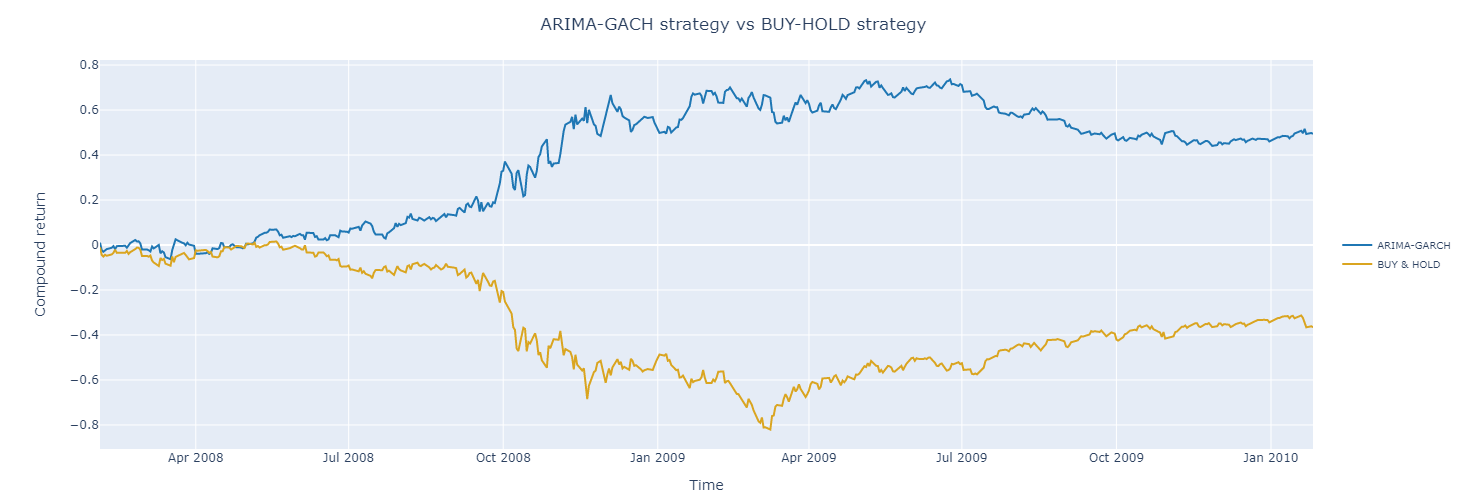

In [90]:
fig = go.Figure([
    go.Scatter(
        name='ARIMA-GARCH',
        x=results.index,
        y=results['strat_curve'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='BUY & HOLD',
        x=results.index,
        y=results['buy_hold_curve'],
        mode='lines',
        line=dict(color='goldenrod'),
    )
])
fig.update_layout(legend=dict(y=0.5, font_size=10), width=1300, height=500, margin=dict(l=100, r=30, b=10, t=60), 
                  title = 'ARIMA-GACH strategy vs BUY-HOLD strategy', title_x=0.5)
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Compound return')
fig.write_html("E:/Directory/Neoma Courses/Data viz Directory/ss.html")
fig.show()